# Compare success of different lineages
Natalia Vélez, July 2020<br />
Last updated April 2021

Now that we've built a graph representation of family trees, we'll use it to compare lineages and operationalize a success measure.

In [1]:
%matplotlib inline

import os, re, glob, datetime, json, sys
from os.path import join as opj

import pandas as pd
import numpy as np
import scipy.stats
from tqdm import notebook

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from networkx.drawing.nx_agraph import graphviz_layout

sys.path.append('..')
from utils import gsearch, int_extract

sns.set_context('talk')
sns.set_style('white')

## Set up data

The format of the maplogs changed at some point during the boundless era; after this point, each change to the map was tagged with an avatar ID. We want to analyze families that started after the launch of this new maplog format and died out before we downloaded the data.

Find starting time:

In [2]:
data_dir = '../../data/publicMapChangeData/bigserver2.onehouronelife.com/'
seed_f = gsearch(opj(data_dir, '*mapSeed.txt'))
seed_t = [int_extract('[0-9]+(?=time)', f) for f in seed_f]
seed_t.sort()

start_t = seed_t[0]

print('Found %i seed files' % len(seed_t))
print('Starting lifelogs at: %s' % datetime.datetime.fromtimestamp(start_t).strftime('%c'))
print(*seed_t, sep='\n')

Found 17 seed files
Starting lifelogs at: Sat Nov 16 04:14:33 2019
1573895673
1574102503
1576038671
1578345720
1578354747
1579713519
1580144896
1581985139
1583642903
1584061484
1585440511
1585512770
1585603481
1587166656
1603997647
1608411674
1609170451


Load lifelog data:

In [3]:
all_eras = pd.read_csv('outputs/all_lifelogs_compact.tsv', sep='\t', index_col=0)
all_eras.head()

/n/home15/nvelezalicea/.conda/envs/py3/lib/python3.9/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,player,avatar,tBirth,parent,birth,tDeath,death,age,cause_of_death,birthX,birthY,deathX,deathY,first,last
0,5ab4f808b01db8bab564fa726ca7dd0439205d4a,4108849,1617678319,4108781,[-13743 -77],1.617679e+09,[-13797 -104],3.59,hunger,-13743,-77,-13797.0,-104.0,TED,GFELL
1,5ab4f808b01db8bab564fa726ca7dd0439205d4a,4108848,1617678300,4108786,[-15498 362],1.617678e+09,[-15498 362],0.22,disconnect,-15498,362,-15498.0,362.0,HERA,POLLY
2,dadea1a71832326c598df59059cf42102e979707,4108842,1617678238,4108778,[-15498 362],1.617680e+09,[-15502 363],22.16,murdered,-15498,362,-15502.0,363.0,SPARTAN,POLLY
3,328dc412f542693dc20d084e99a7367e4fe4aae4,4108839,1617678208,4108784,[-13754 -85],1.617682e+09,[-13765 -64],60.00,oldAge,-13754,-85,-13765.0,-64.0,SERANA,GFELL
4,e65b7bfa037a3287869cb682b648c68e52ad05d4,4108837,1617678173,4108782,[-15796 -205],1.617679e+09,[-15803 -204],14.85,murdered,-15796,-205,-15803.0,-204.0,TJ,NaN


Load families & find families that started after the new maplog format:

In [4]:
fam_df = pd.read_csv('outputs/family_playerID.tsv', sep='\t', index_col=0)
in_era = fam_df.groupby('family')['avatar'].agg('count').reset_index()
in_era['start_t'] = in_era.family.apply(lambda f: int_extract('(?<=time-)[0-9]+', f))

# Trim families that started before the new map logs
in_era = in_era[in_era['start_t'] >= start_t]

print('Total families: %i' % in_era.shape[0])
in_era.head()

/n/home15/nvelezalicea/.conda/envs/py3/lib/python3.9/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Total families: 14874


,family,avatar,start_t
49989,time-1573895755_eve-2276905_name-ZABICKI,19,1573895755
49990,time-1573895904_eve-2276911_name-ROHRER,3,1573895904
49991,time-1573896101_eve-2276917_name-BADA,36,1573896101
49992,time-1573896134_eve-2276919_name-SARINA,71,1573896134
49993,time-1573896495_eve-2276927_name-LISSADE,496,1573896495


Remove incomplete families (i.e., lineages that were still alive at the time of the data download)

In [5]:
filtered_fams = pd.merge(in_era[['family']], fam_df, how='left')
filtered_lifelogs = pd.merge(filtered_fams, all_eras)

idx = filtered_lifelogs.groupby(['family'])['tBirth'].transform(max) == filtered_lifelogs['tBirth']
last_descendants = filtered_lifelogs[idx].copy()
complete_fams = last_descendants.groupby('family')['tDeath'].agg(lambda group: all(np.isfinite(group))).reset_index()
complete_fams = complete_fams[complete_fams.tDeath]
complete_fams = pd.merge(complete_fams[['family']], in_era)

print('Removed %i incomplete families' % (in_era.shape[0] - complete_fams.shape[0]))
print('%i families remaining' % complete_fams.shape[0])
complete_fams.head()

Removed 13 incomplete families
14861 families remaining


,family,avatar,start_t
0,time-1573895755_eve-2276905_name-ZABICKI,19,1573895755
1,time-1573895904_eve-2276911_name-ROHRER,3,1573895904
2,time-1573896101_eve-2276917_name-BADA,36,1573896101
3,time-1573896134_eve-2276919_name-SARINA,71,1573896134
4,time-1573896495_eve-2276927_name-LISSADE,496,1573896495


Exclude infant births from lifelogs:


In [6]:
complete_descendants = pd.merge(complete_fams[['family']], fam_df)

infant_lifelogs = pd.merge(complete_descendants, all_eras)
noninfant_lifelogs = infant_lifelogs[(infant_lifelogs['cause_of_death'] != 'disconnect') & (infant_lifelogs['age'] > 2)]

print('Removed %i infant disconnects' % (infant_lifelogs.shape[0] - noninfant_lifelogs.shape[0]))
print(noninfant_lifelogs.shape)
noninfant_lifelogs.head()

Removed 64359 infant disconnects
(712313, 16)


,family,avatar,player,tBirth,parent,birth,tDeath,death,age,cause_of_death,birthX,birthY,deathX,deathY,first,last
0,time-1573895755_eve-2276905_name-ZABICKI,2276941,c6ed44a5ce9e67f2c5a34f32be544edd78cbe601,1573897198,2276905,[-5114 -1399],1.573899e+09,[-5153 -1379],25.79,murdered,-5114,-1399,-5153.0,-1379.0,SAMMY,ZABICKI
1,time-1573895755_eve-2276905_name-ZABICKI,2276935,e7098854c1756fbc047243a7376e1c0dbd99b35d,1573896961,2276905,[-5130 -1408],1.573899e+09,[-5131 -1383],28.37,murdered,-5130,-1408,-5131.0,-1383.0,CUCA,ZABICKI
3,time-1573895755_eve-2276905_name-ZABICKI,2276922,0c7bc0236deae0bb888f63c4f4d94f4ab7cefad1,1573896361,2276905,[-5124 -1406],1.573897e+09,[-5132 -1395],9.73,hunger,-5124,-1406,-5132.0,-1395.0,HANA,ZABICKI
5,time-1573895755_eve-2276905_name-ZABICKI,2276914,e417361f8e2770a2a5647353af05f6e621be69c0,1573895976,2276905,[-5133 -1397],1.573898e+09,[-5122 -1400],41.77,murdered,-5133,-1397,-5122.0,-1400.0,NYANA,ZABICKI
6,time-1573895755_eve-2276905_name-ZABICKI,2276909,b0527ef2371111cb11369f4a5fe021c1bdb06ed9,1573895873,2276905,[-5121 -1398],1.573899e+09,[-5107 -1389],45.99,murdered,-5121,-1398,-5107.0,-1389.0,MASA,ZABICKI


Remove singleton families:

In [7]:
final_families = noninfant_lifelogs.groupby('family')['avatar'].agg('count').reset_index()
final_families = final_families[final_families.avatar > 1]

print('Removed %i singleton families' % (complete_fams.shape[0] - final_families.shape[0]))
print('%i families remaining' % final_families.shape[0])
final_families.head()

Removed 8684 singleton families
6177 families remaining


,family,avatar
0,time-1573895755_eve-2276905_name-ZABICKI,16
1,time-1573895904_eve-2276911_name-ROHRER,3
2,time-1573896101_eve-2276917_name-BADA,32
3,time-1573896134_eve-2276919_name-SARINA,63
4,time-1573896495_eve-2276927_name-LISSADE,440


Filter singleton families out of lifelogs:

In [8]:
final_lifelogs = pd.merge(final_families[['family']], noninfant_lifelogs)
print(noninfant_lifelogs.shape)
print(final_lifelogs.shape)
final_lifelogs.head()

(712313, 16)
(703653, 16)


,family,avatar,player,tBirth,parent,birth,tDeath,death,age,cause_of_death,birthX,birthY,deathX,deathY,first,last
0,time-1573895755_eve-2276905_name-ZABICKI,2276941,c6ed44a5ce9e67f2c5a34f32be544edd78cbe601,1573897198,2276905,[-5114 -1399],1.573899e+09,[-5153 -1379],25.79,murdered,-5114,-1399,-5153.0,-1379.0,SAMMY,ZABICKI
1,time-1573895755_eve-2276905_name-ZABICKI,2276935,e7098854c1756fbc047243a7376e1c0dbd99b35d,1573896961,2276905,[-5130 -1408],1.573899e+09,[-5131 -1383],28.37,murdered,-5130,-1408,-5131.0,-1383.0,CUCA,ZABICKI
2,time-1573895755_eve-2276905_name-ZABICKI,2276922,0c7bc0236deae0bb888f63c4f4d94f4ab7cefad1,1573896361,2276905,[-5124 -1406],1.573897e+09,[-5132 -1395],9.73,hunger,-5124,-1406,-5132.0,-1395.0,HANA,ZABICKI
3,time-1573895755_eve-2276905_name-ZABICKI,2276914,e417361f8e2770a2a5647353af05f6e621be69c0,1573895976,2276905,[-5133 -1397],1.573898e+09,[-5122 -1400],41.77,murdered,-5133,-1397,-5122.0,-1400.0,NYANA,ZABICKI
4,time-1573895755_eve-2276905_name-ZABICKI,2276909,b0527ef2371111cb11369f4a5fe021c1bdb06ed9,1573895873,2276905,[-5121 -1398],1.573899e+09,[-5107 -1389],45.99,murdered,-5121,-1398,-5107.0,-1389.0,MASA,ZABICKI


## Check full sample

Final sample size calculation!

In [9]:
final_sample = final_lifelogs[['family', 'player', 'avatar']].agg('nunique')
print('N =\t%i families' % final_sample['family'])
print('\t%i avatars' % final_sample['avatar'])
print('\t%i unique players' % final_sample['player'])

N =	6177 families
	703653 avatars
	38564 unique players


Save inclusions (we'll upload this at the end):

In [10]:
inc_families = list(np.unique(final_lifelogs.family))
inc_players = list(np.unique(final_lifelogs.player))
inc_avatars = list(np.unique(final_lifelogs.avatar))

Lives per player in current sample:

Median # lives: 4.00
Min # lives: 1
Max # lives: 2201


/n/home15/nvelezalicea/.conda/envs/py3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


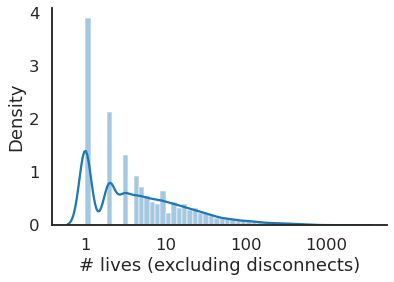

In [11]:
player_summ = final_lifelogs.groupby('player')['avatar'].agg('count').reset_index()
player_summ = player_summ.rename(columns={'avatar': 'n'})
player_summ.head()

# Plot
print('Median # lives: %0.2f' % np.median(player_summ['n']))
print('Min # lives: %i' % np.min(player_summ['n']))
print('Max # lives: %i' % np.max(player_summ['n']))

fig,ax = plt.subplots()
sns.distplot(np.log10(player_summ['n']),ax=ax)
ax.set(xlabel='# lives (excluding disconnects)', xticks=range(4), xticklabels=[10**x for x in range(4)])
sns.despine()

Start and end times:

In [12]:
t_fmt = '%Y-%m-%dT%H:%M:%S %Z'

start_t = np.min(final_lifelogs['tBirth'])
start_date = datetime.datetime.fromtimestamp(start_t).strftime(t_fmt)

end_t = np.max(final_lifelogs['tDeath'])
end_date = datetime.datetime.fromtimestamp(end_t).strftime(t_fmt)

print('First lineage starts at: %s' % start_date)
print('Lineages end at: %s' % end_date)

First lineage starts at: 2019-11-16T04:15:55 
Lineages end at: 2021-04-06T00:03:28 


What is the longest-lived lineage?

In [13]:
family_t = final_lifelogs.groupby('family').agg({'tBirth': 'min', 'tDeath': 'max'}).reset_index()
family_t['duration_hours'] = (family_t['tDeath'] - family_t['tBirth'])/60/60
family_t['duration_days'] = family_t['duration_hours']/24
family_t = family_t.sort_values(by='duration_hours', ascending=False).reset_index(drop=True)
family_t.head()

,family,tBirth,tDeath,duration_hours,duration_days
0,time-1609746195_eve-3833245_name-STALLINS,1609746195,1.610329e+09,161.972222,6.748843
1,time-1611138522_eve-3897231_name-LUCKY,1611138522,1.611671e+09,147.875833,6.161493
2,time-1611388293_eve-3906808_name-ARTEMENKO,1611388293,1.611867e+09,132.887778,5.536991
3,time-1610335007_eve-3864700_name-APRIL,1610335007,1.610808e+09,131.353889,5.473079
4,time-1607255144_eve-3661190_name-RED,1607255144,1.607709e+09,126.131667,5.255486


/n/home15/nvelezalicea/.conda/envs/py3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[[<matplotlib.axis.XTick at 0x2b5bfb428d00>,
 [Text(-2.0, 0, '0.01'),
  Text(-1.0, 0, '0.1'),
  Text(0.0, 0, '1.0'),
  Text(1.0, 0, '10.0'),
  Text(2.0, 0, '100.0')],
 Text(0.5, 0, 'Family duration (hours)')]

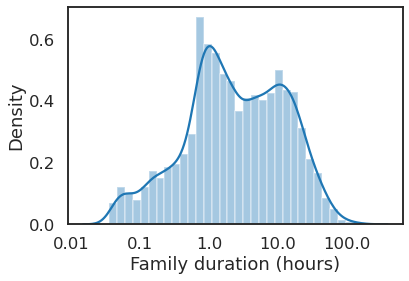

In [14]:
ax = sns.distplot(np.log10(family_t.duration_hours))
log_xticks = ax.get_xticks()
log_xticks = log_xticks[1:-1]
ax.set(xticks = log_xticks, xticklabels = [10**x for x in log_xticks],
       xlabel = 'Family duration (hours)')

In [15]:
family_t['duration_hours'].agg(['min', 'max', 'median'])

min         0.035556
max       161.972222
median      2.264444
Name: duration_hours, dtype: float64

## Compute summary statistics

### Family size and life expectancy

/n/home15/nvelezalicea/.conda/envs/py3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


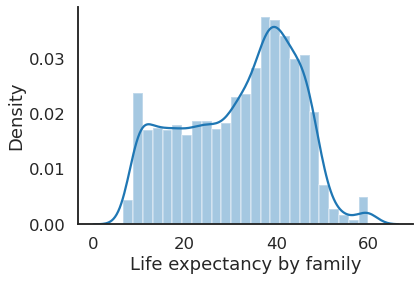

In [16]:
life_expectancy = final_lifelogs.groupby('family')['age'].agg(['mean', 'count']).reset_index()
ax = sns.distplot(life_expectancy['mean'])
ax.set(xlabel = 'Life expectancy by family')
sns.despine()

/n/home15/nvelezalicea/.conda/envs/py3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


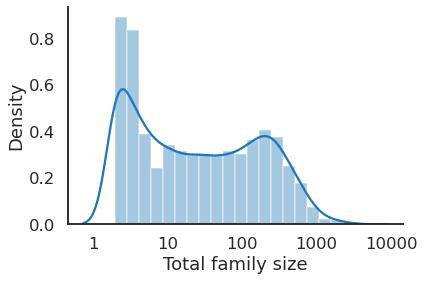

In [17]:
ax = sns.distplot(np.log10(life_expectancy['count']))
ax.set(xlabel = 'Total family size', xticks=range(5), xticklabels=[10**i for i in range(5)])
sns.despine()

In [18]:
scipy.stats.mode(life_expectancy['count'])

ModeResult(mode=array([2]), count=array([885]))

### # of generations (Chain length)

Helper: Read JSON files

In [19]:
def open_graph(f):
    with open(f) as handle:
        graph_data = json.load(handle)
    return nx.json_graph.node_link_graph(graph_data)

Find longest chain in family graphs

In [20]:
chain_list = []
family_generations = []

for f in notebook.tqdm(inc_families):
    fam_file = 'outputs/families/families_%s.json' % f
    fam_graph = open_graph(fam_file)
    fam_chain = nx.algorithms.dag_longest_path(fam_graph)
    
    eve = re.search(r'(?<=eve-)([0-9]+)', f).group(0)
    
    chain_list.append((f, len(fam_chain)))

  0%|          | 0/6177 [00:00<?, ?it/s]

In [21]:
chain_df = pd.DataFrame(chain_list, columns=['family', 'longest_path'])
chain_df.head()

,family,longest_path
0,time-1573895755_eve-2276905_name-ZABICKI,3
1,time-1573895904_eve-2276911_name-ROHRER,2
2,time-1573896101_eve-2276917_name-BADA,5
3,time-1573896134_eve-2276919_name-SARINA,9
4,time-1573896495_eve-2276927_name-LISSADE,46


In [22]:
chain_df['longest_path'].agg(['min', 'max', 'median'])

min         2.0
max       357.0
median      5.0
Name: longest_path, dtype: float64

/n/home15/nvelezalicea/.conda/envs/py3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 0, '# of generations'),
 [Text(0, 0, '1'), Text(1, 0, '10'), Text(2, 0, '100')]]

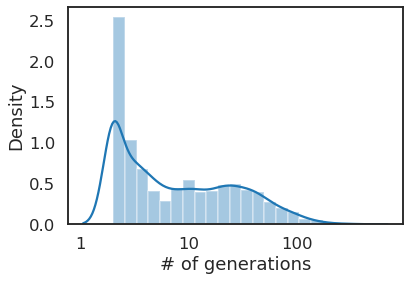

In [23]:
ax = sns.distplot(np.log10(chain_df['longest_path']))
ax.set(xlabel = '# of generations', xticks=np.arange(3), xticklabels=[10**x_i for x_i in np.arange(3)])

In [24]:
chain_df.sort_values(by='longest_path', ascending=False).head()

,family,longest_path
5543,time-1609746195_eve-3833245_name-STALLINS,357
5624,time-1611138522_eve-3897231_name-LUCKY,330
5578,time-1610335007_eve-3864700_name-APRIL,296
5637,time-1611388293_eve-3906808_name-ARTEMENKO,296
5245,time-1607255144_eve-3661190_name-RED,292


## Modeling success

Criterion for "success": Reaching age 14 (viability fitness)

In [25]:
mortality_df = final_lifelogs.copy()
mortality_df['adult'] = (mortality_df['age'] >= 14)*1
mortality_df = mortality_df[['family', 'avatar', 'adult']]

mortality_summ = mortality_df.groupby('family')['adult'].agg(['sum', 'count']).reset_index()
mortality_summ['sum'] = mortality_summ['sum'].astype(np.int)
mortality_summ.head()

,family,sum,count
0,time-1573895755_eve-2276905_name-ZABICKI,9,16
1,time-1573895904_eve-2276911_name-ROHRER,1,3
2,time-1573896101_eve-2276917_name-BADA,14,32
3,time-1573896134_eve-2276919_name-SARINA,33,63
4,time-1573896495_eve-2276927_name-LISSADE,311,440


Compute beta distribution for each family

Prior: Uniform
$$
\theta \sim \mathrm{Beta}(\alpha_0, \beta_0) \\
\alpha_0 = \beta_0 = 1
$$

Posterior-sufficient statistics:
$$
\theta | D \sim \mathrm{Beta}(\alpha_0 + k, \beta_0 + N - k) \\ 
a = \alpha_0 + k \\
b = \beta_0 + N - k
$$

In [26]:
def beta_mean(row): return scipy.stats.beta.mean(row['a'], row['b'])
def beta_var(row): return scipy.stats.beta.var(row['a'], row['b'])

mortality_summ['a'] = 3 + mortality_summ['sum']
mortality_summ['b'] = 3 + mortality_summ['count'] - mortality_summ['sum']
mortality_summ['beta_mean'] = mortality_summ.apply(beta_mean, axis=1)
mortality_summ['beta_var'] = mortality_summ.apply(beta_var, axis=1)
mortality_summ['snr'] = mortality_summ['beta_mean']/mortality_summ['beta_var']
mortality_summ['weighted_size'] = mortality_summ['beta_mean']*mortality_summ['count']
mortality_summ = pd.merge(mortality_summ, chain_df, on = 'family')
mortality_summ.to_csv('outputs/family_fitness.tsv', sep='\t', index=False)
mortality_summ.head()

,family,sum,count,a,b,beta_mean,beta_var,snr,weighted_size,longest_path
0,time-1573895755_eve-2276905_name-ZABICKI,9,16,12,10,0.545455,0.010780,50.600000,8.727273,3
1,time-1573895904_eve-2276911_name-ROHRER,1,3,4,5,0.444444,0.024691,18.000000,1.333333,2
2,time-1573896101_eve-2276917_name-BADA,14,32,17,21,0.447368,0.006339,70.571429,14.315789,5
3,time-1573896134_eve-2276919_name-SARINA,33,63,36,33,0.521739,0.003565,146.363636,32.869565,9
4,time-1573896495_eve-2276927_name-LISSADE,311,440,314,132,0.704036,0.000466,1510.318182,309.775785,46


### Compare candidate success measures

Beta mean:

/n/home15/nvelezalicea/.conda/envs/py3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


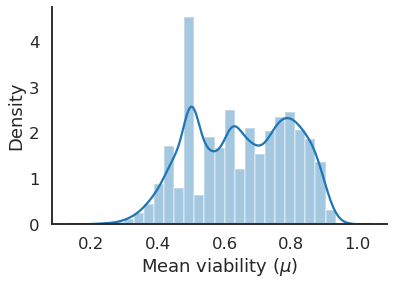

In [27]:
ax = sns.distplot(mortality_summ['beta_mean'])
ax.set(xlabel = 'Mean viability ($\mu$)')
sns.despine()

Distribution of SNR:

/n/home15/nvelezalicea/.conda/envs/py3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


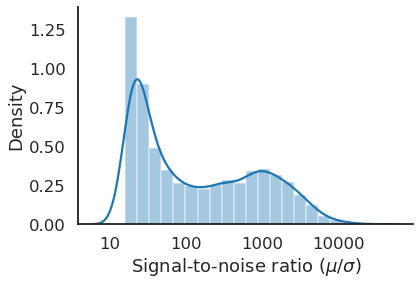

In [28]:
ax = sns.distplot(np.log10(mortality_summ['snr']))
ax.set(xlabel='Signal-to-noise ratio ($\mu/\sigma$)',
       xticks = np.arange(1,5), xticklabels=[10**x for x in np.arange(1,5)])
sns.despine()

Distribution of weighted size:

/n/home15/nvelezalicea/.conda/envs/py3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 0, 'Weighted family size ($\\mu N$)'),
 [Text(0, 0, '1'),
  Text(1, 0, '10'),
  Text(2, 0, '100'),
  Text(3, 0, '1000'),
  Text(4, 0, '10000')]]

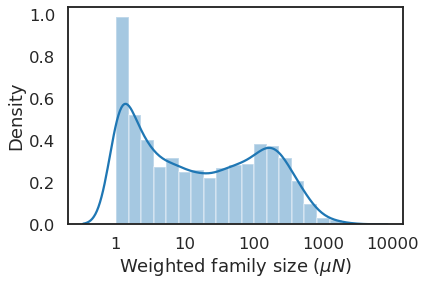

In [29]:
ax = sns.distplot(np.log10(mortality_summ['weighted_size']))
ax.set(xlabel='Weighted family size ($\mu N$)',
       xticks=np.arange(0, 5), xticklabels=[10**x for x in np.arange(0, 5)])

Distribution of # adults:

In [30]:
mortality_summ[mortality_summ['sum'] ==0]

,family,sum,count,a,b,beta_mean,beta_var,snr,weighted_size,longest_path
3335,time-1594856179_eve-3178148_name-CHARLES,0,4,3,7,0.3,0.019091,15.714286,1.2,2


In [31]:
final_lifelogs[final_lifelogs.family == 'time-1594856179_eve-3178148_name-CHARLES']

,family,avatar,player,tBirth,parent,birth,tDeath,death,age,cause_of_death,birthX,birthY,deathX,deathY,first,last
354237,time-1594856179_eve-3178148_name-CHARLES,3178180,3693bb0d002d8b9af7988ac704a5b59fba78a43d,1594856682,3178148,[-18978 -63],1.594857e+09,[-19151 -88],6.29,hunger,-18978,-63,-19151.0,-88.0,REEDIE,CHARLES
354238,time-1594856179_eve-3178148_name-CHARLES,3178169,034bf43fd22eeba37603031c71437958c2bd6694,1594856528,3178148,[-18952 -65],1.594857e+09,[-19120 -80],8.46,hunger,-18952,-65,-19120.0,-80.0,MOON,CHARLES
354239,time-1594856179_eve-3178148_name-CHARLES,3178151,3693bb0d002d8b9af7988ac704a5b59fba78a43d,1594856219,3178148,[-19088 -54],1.594857e+09,[-18979 -56],5.59,hunger,-19088,-54,-18979.0,-56.0,ROSE,CHARLES
354240,time-1594856179_eve-3178148_name-CHARLES,3178150,cbd38b7f6a5e1fc1cc47bf30ccda1ed9d0cc8c89,1594856209,3178148,[-19093 -65],1.594857e+09,[-18977 -64],8.57,hunger,-19093,-65,-18977.0,-64.0,GEM,CHARLES


In [32]:
all_eras[all_eras.avatar == 3178148]

,player,avatar,tBirth,parent,birth,tDeath,death,age,cause_of_death,birthX,birthY,deathX,deathY,first,last
482519,b0bf435c1dd467204a8075898e64fe6f844c5064,3178148,1594856179,-1,[-19103 -47],1.594857e+09,[-19218 -68],29.92,disconnect,-19103,-47,-19218.0,-68.0,EVE,CHARLES


/n/home15/nvelezalicea/.conda/envs/py3/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/n/home15/nvelezalicea/.conda/envs/py3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


OverflowError: cannot convert float infinity to integer

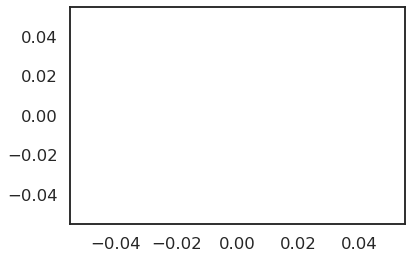

In [33]:
ax = sns.distplot(np.log10(mortality_summ['sum']))
ax.set(xlabel='# of adults', xticks = np.arange(0,5), xticklabels=[10**x for x in np.arange(0,5)])

### Plot representative families

Split data into quartiles:

In [ ]:
success = 'sum' # Success metric
mortality_summ['quantile'] = pd.qcut(mortality_summ[success], 4, labels=False)

What are the quantiles?

In [ ]:
success_q = scipy.stats.mstats.mquantiles(mortality_summ[success], prob=[0.25, 0.5, 0.75, 1])
mortality_summ['log_n'] = np.log10(mortality_summ['sum'])

# Plot!
q_log = np.log10(success_q)
plt.figure(figsize=(12,4))
for q in q_log:
    plt.axvline(q, color='#aaaaaa', linestyle='--')

ax = sns.distplot(mortality_summ['log_n'])
ax.set_xticks(range(5))
labels = [10**t for t in ax.get_xticks()]
ax.set(xlabel='# of adults', xticklabels=labels)
sns.despine()

Plot representative family trees from each quartile:

In [ ]:
np.random.seed(526)
representative_families = np.array([np.random.choice(group['family'], 10) 
                                    for name,group in mortality_summ.groupby('quantile')])
rep_list = np.array(representative_families)
rep_list = rep_list.flatten()

rep_info = mortality_summ.copy()
rep_info = rep_info[rep_info['family'].isin(rep_list)]
rep_info = rep_info.reset_index(drop=True)
rep_info = rep_info.sort_values('quantile')
rep_info.to_csv('plots/fitness_quantiles/selected_families.tsv', sep='\t', index=None)
rep_info.head()

In [ ]:
for quant in notebook.tqdm(range(4)):
    for f in notebook.tqdm(representative_families[quant]):
        fam_file = 'outputs/families/families_%s.json' % f
        out_file = 'plots/fitness_quantiles/families_Q%i_%s.png' % (quant+1, f)

        # Load graph and remove infant deaths
        fam_graph = open_graph(fam_file)

        # Figure size (based on graphviz layout)
        nx.nx_agraph.write_dot(fam_graph,'fam.dot')
        pos=graphviz_layout(fam_graph, prog='dot')
        pos_coords = pd.DataFrame(list(pos.values()), columns=['x','y']).agg(['max', 'min'])
        w = (pos_coords.loc['max', 'x'] - pos_coords.loc['min', 'x'])/150
        h = (pos_coords.loc['max', 'y'] - pos_coords.loc['min', 'y'])/150

        # Adjust for 2-member families
        w = max(w, 2)
        h = max(h, 2)

        # Node color (based on whether individuals reached maturity)
        fam_nodes = list(fam_graph.nodes)
        fam_nodes = [int(n) for n in fam_nodes]

        fam_attr = mortality_df[['avatar', 'adult']].copy()
        fam_attr = fam_attr[fam_attr['avatar'].isin(fam_nodes)]
        fam_attr = fam_attr.set_index('avatar')
        fam_attr = fam_attr.to_dict()
        
        fam_color = []
        for n in fam_nodes:
            if n in infant_deaths:
                fam_color.append('#cccccc')
            else:
                if fam_attr['adult'][n] == 1:
                    fam_color.append('#4ab1ff')
                else:
                    fam_color.append('#4ab1ff')

#         fam_color = [fam_attr['adult'][n] == 1 for n in fam_nodes]
#         fam_color = ['#4ab1ff' if c else '#cccccc' for c in fam_color]

        plt.figure(3,figsize=(w,h)) 
        nx.draw(fam_graph, pos, with_labels=False, arrows=True, node_color=fam_color)
        plt.savefig(out_file, transparent=True)
        plt.close()

## Plots for talk

<div style='background-color:red;color:white;'>TODO: The plots below should be moved elsewhere to preserve order!</div>
Relationship between family and repertoire size:

In [ ]:
rep_df = pd.read_csv('../3_technology/outputs/family_repertoire.tsv', sep='\t')
rep_df.head()

In [ ]:
family_n = mortality_summ[['family','sum', 'log_n']]
family_rep = rep_df[['family', 'breadth','log_breadth']]
n_rep = pd.merge(family_n, family_rep, on='family')
n_rep.head()

Max items possible?

In [ ]:
item_df = pd.read_csv('../4_techtree/num_unique_ingredients.csv')
n_items = len(item_df)
print('# items: %i' % n_items)
item_df.head()

Distribution of repertoire sizes

In [ ]:
rep_q = scipy.stats.mstats.mquantiles(rep_df['log_breadth'], prob=[0.25, 0.5, 0.75, 1])
print(rep_q)

plt.figure(figsize=(12,4))
# for q in rep_q:
#     plt.axvline(q, color='#aaaaaa', linestyle='--')
#plt.axvspan(0, q_log[0], alpha=0.5, color='red') 

ax = sns.distplot(rep_df['log_breadth'], bins=20)
ax.set_xlim(left=0)
ax.set_xticks(range(5))
plt.axvline(np.log10(n_items), linestyle='--', color = '#f5a442')
labels = [10**t for t in ax.get_xticks()]
ax.set(xlabel='Repertoire size', xticklabels=labels)
sns.despine()

In [ ]:
g = sns.jointplot(data=n_rep, x='log_breadth', y='log_n', kind='reg', lowess=True,
                  marginal_kws={'bins':20},
                  scatter_kws={'alpha':0.01, 'color': '#A5C8E1'})
ticks = np.arange(4)
tick_labels = [10**t for t in ticks]
g.ax_joint.set(xticks = ticks, yticks = ticks,
               xticklabels = tick_labels, yticklabels = tick_labels,
               xlabel='Viability',
               ylabel='Repertoire size')

In [ ]:
gini_df = pd.read_csv('../3_technology/outputs/family_gini.tsv', sep='\t')
gini_df.head()

In [ ]:
gini_rep = pd.merge(gini_df, rep_df, on='family')
gini_rep.head()

In [ ]:
fig = plt.figure(figsize=(6,6))
ax = sns.regplot(x='gini', y='log_breadth', data=gini_rep,
                 scatter_kws={'alpha': 0.05, 'color': '#A5C8E1'}, 
                 line_kws = {'color': '#2276B4'}, lowess=True)
yticks =  np.arange(0,5)
ax.set_yticks(yticks)
yticklabels = [10**y for y in yticks]
ax.set(xlabel = 'Innovation inequality (G)',
       xlim = (0,1),
       ylabel = 'Repertoire size',
       yticklabels=yticklabels)
sns.despine()

In [ ]:
plt.figure(figsize=(7,5))
equal_dist = np.array([0,1,2,3,4])
ax = sns.distplot(equal_dist, kde=False, hist_kws={'density': False}, bins=5)
ax.set(xlim = (0,11), ylim = (0,5),
       xticks = np.arange(0,11),
       yticks = np.arange(6),
       xlabel='# discoveries',
       ylabel='# players')
sns.despine()

## Living population size over time
<div style='background-color:red;color:white;'>TODO: The plots below should be moved elsewhere to narrow the scope of this notebook!</div>

In [ ]:
living_list = []
for fam in notebook.tqdm(inc_families):
    fam_df = final_lifelogs[final_lifelogs['family'] == fam].copy().reset_index(drop=True)
    t = fam_df['tBirth'].values
    for ti in t:
        is_alive = (fam_df['tBirth'] <= ti) & (fam_df['tDeath'] > ti)
        pop = np.sum(is_alive)
        living_list.append((fam, ti, pop))

In [ ]:
living_df = pd.DataFrame(living_list, columns = ['family', 't', 'population'])
living_df = living_df.sort_values(by=['family', 't'], ascending=True).reset_index(drop=True)
living_df['t0'] = living_df.groupby('family')['t'].transform('first')
living_df['t_elapsed'] = (living_df['t'] - living_df['t0'])/60/60
living_df.head()

Plot a subset

In [ ]:
np.random.seed(526)
random_families = np.random.choice(inc_families, size=10, replace=False)
random_subset = living_df[living_df['family'].isin(random_families)]
g = sns.relplot(data=random_subset, x='t_elapsed', y='population', hue='family', kind='line',
                 height=6, aspect=2, alpha = 0.5)
g.set(xlabel = 'Time elapsed (hours)', ylabel = 'Population size')
g._legend.remove()

Maximum population size

In [ ]:
max_pop = living_df.groupby('family')['population'].agg('max').reset_index()
ax = sns.distplot(max_pop['population'])
ax.set(xlabel = 'Maximum living population size')
sns.despine()

In [ ]:
max_pop['population'].agg(['min', 'max', 'median'])